In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

from pystac_client import Client # to access STAC catalogs
import planetary_computer # To sign items from the MPC STAC catalog
from IPython.display import Image # To nicely display images

In [39]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [40]:
ib_collection = catalog.get_child('io-biodiversity')
ib_collection

<CollectionClient id=io-biodiversity>

In [41]:
# NCEAS bounding box (as a GeoJSON)
phx_bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 32.974108],
            [-112.826843, 33.863574],
            [-111.184387, 33.863574],
            [-111.184387, 32.974108],
            [-112.826843, 32.974108]
        ]
    ],
}

# Temporal range of interest
time_range = "2017-01-01/2021-01-01"

In [42]:
# Catalog.search
search = catalog.search(
    collections=["io-biodiversity"],
    intersects=phx_bbox,
    datetime = time_range
)
items = search.item_collection()

In [43]:
# Select years 2020 and 2017
item_2020 = items[0]
item_2017 = items[3]

In [44]:
for key in item_2020.assets.keys():
    print(key, "--", item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [45]:
for key in item_2017.assets.keys():
    print(key, "--", item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [46]:
Image(url=item_2020.assets["rendered_preview"].href, width=500)

In [47]:
Image(url=item_2017.assets["rendered_preview"].href, width=500)

# Phoenix Shapefile

<Axes: >

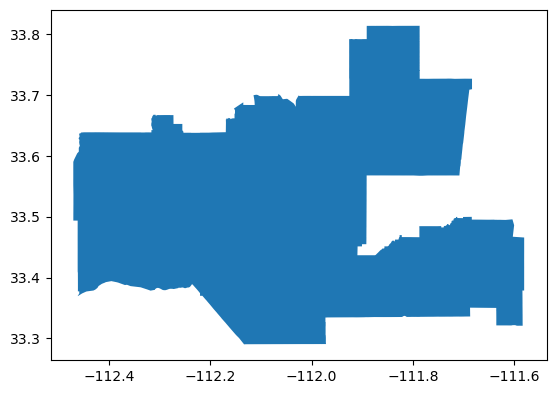

In [48]:
az_shp = gpd.read_file("data/tl_2020_04_cousub.shp")
phx_shp = az_shp[az_shp["NAME"]=="Phoenix"]
#phx_shp = phx_shp.to_crs(epsg=2223)
phx_shp.plot()

In [49]:
rast_2020 = rioxr.open_rasterio(item_2020.assets["data"].href)
rast_2020 = rast_2020.squeeze().drop_vars("band")

In [50]:
rast_2017 = rioxr.open_rasterio(item_2017.assets["data"].href)
rast_2017 = rast_2017.squeeze().drop_vars("band")

In [51]:
phx_clip_2020 = (rast_2020.rio.clip_box(*phx_shp.total_bounds)
                .rio.clip(phx_shp.geometry))

In [52]:
phx_clip_2017 = (rast_2017.rio.clip_box(*phx_shp.total_bounds)
                .rio.clip(phx_shp.geometry))

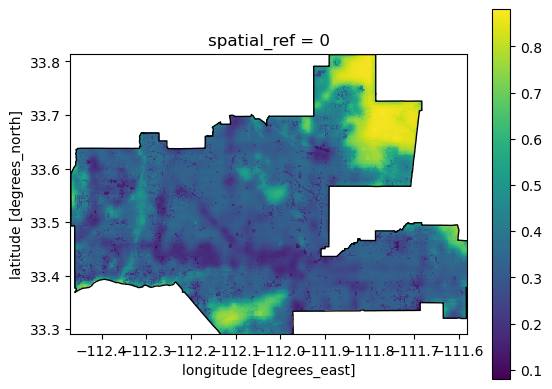

In [53]:
# Plot raster boundary, fire perimeter, CA boundary
fig, ax = plt.subplots()
phx_clip_2020.plot(ax=ax)
phx_shp.plot(ax=ax, color=(0.1, 0.2, 0.5, 0.01), edgecolor="black")

plt.show()

# BII Percent 

## Area

In [54]:
# Reproject to a metric CRS (e.g., UTM)
phx_shp_projected = phx_shp.to_crs(epsg=2223)  # Replace with the correct UTM zone for Arizona

# Calculate the total area
total_area = phx_shp_projected.geometry.area.sum() / 1e6  # In square kilometers
print(f"Total area of Phoenix subdivision: {total_area:.2f} square meters")

Total area of Phoenix subdivision: 30304.99 square meters


## Percent of area

In [55]:
phx_clip_2017_BII = phx_clip_2017 >= 0.75
phx_clip_2020_BII = phx_clip_2020 >= 0.75

In [56]:
# Calculate the number of pixels meeting the threshold
phx_2017_BII_area = phx_clip_2017_BII.sum().item()
phx_2020_BII_area = phx_clip_2020_BII.sum().item()

# Total number of pixels 
phx_2017_total_area = phx_clip_2017.sum().item()
phx_2020_total_area = phx_clip_2020.sum().item()

In [57]:
# Calculate the percentage of the total area with BII >= 0.75
bii_pct_2017 = (phx_2017_BII_area / phx_2017_total_area) * 100
bii_pct_2020 = (phx_2020_BII_area / phx_2020_total_area) * 100

# Print the results
print(f"Percentage of area with BII >= 0.75 in 2017: {bii_pct_2017:.2f}%")
print(f"Percentage of area with BII >= 0.75 in 2020: {bii_pct_2020:.2f}%")

Percentage of area with BII >= 0.75 in 2017: 18.67%
Percentage of area with BII >= 0.75 in 2020: 17.18%


# Area Lost

In [58]:
phx_flip = (phx_clip_2017_BII ^ phx_clip_2020_BII)
phx_flip = xr.where(phx_flip, 1, np.nan)

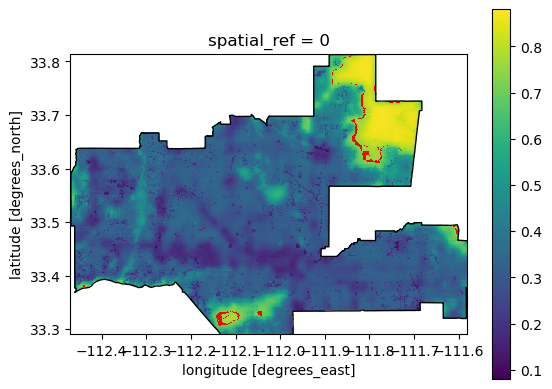

In [61]:
# Plot raster boundary, fire perimeter, CA boundary
fig, ax = plt.subplots()
phx_clip_2020.plot(ax=ax)
phx_shp.plot(ax=ax, color=(0.1, 0.2, 0.5, 0.01), edgecolor="black")
phx_flip.plot(ax=ax, cmap="brg", add_colorbar=False)

plt.show()